In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
from os import listdir, makedirs
import matplotlib.pyplot as plt
from keras import layers, models, optimizers, regularizers, losses
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras.preprocessing import image
from keras.datasets import mnist
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K

import warnings
warnings.filterwarnings('ignore')
print(os.listdir("/home/yaagocruuz/Documentos/git/Topicos3/Trabalho Final/"))

/home/yaagocruuz/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


['retrain.py', '.ipynb_checkpoints', 'sem_finetuning.ipynb', 'dataset', 'Trabalho Final.ipynb']


In [4]:
RESOLUTION = 139
BATCH_SIZE = 64


data_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2,
                                  horizontal_flip=True, validation_split=0.20)

train_generator = data_datagen.flow_from_directory(
        "dataset/",
        classes=['Caroline_Kennedy', 'Edward_Moore_Kennedy', 'Eunice_Kennedy_Shriver', 'Jacqueline_Lee_Bouvier', 
                 'John_F_Kennedy_Jr', 'John_Fitzgerald_Kennedy', 'Joseph_P_Kennedy_Sr', 
                 'Robert_Francis_Kennedy', 'Rose_Elizabeth_Fitzgerald', 
                 'Rosemary_Kenndy', 'Outros'],
        target_size=(RESOLUTION, RESOLUTION),
        batch_size=BATCH_SIZE,
        class_mode='categorical', subset="training")

val_generator = data_datagen.flow_from_directory(
        "dataset/",
        classes=['Caroline_Kennedy', 'Edward_Moore_Kennedy', 'Eunice_Kennedy_Shriver', 'Jacqueline_Lee_Bouvier', 
                 'John_F_Kennedy_Jr', 'John_Fitzgerald_Kennedy', 
                 'Joseph_P_Kennedy_Sr', 'Robert_Francis_Kennedy', 'Rose_Elizabeth_Fitzgerald', 
                 'Rosemary_Kenndy', 'Outros'],
        target_size=(RESOLUTION, RESOLUTION),
        batch_size=BATCH_SIZE,
        class_mode='categorical', subset="validation")

Found 228 images belonging to 11 classes.
Found 53 images belonging to 11 classes.


In [3]:
# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(139,139,3))

In [5]:
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(11, activation='softmax')(x)

In [6]:
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [7]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

In [8]:
# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

In [9]:
# train the model on the new data for a few epochs
model.fit_generator(generator=train_generator, epochs=100, validation_data=val_generator)

Epoch 1/100
4/4 [==============================] - 30s 8s/step - loss: 8.1350 - acc: 0.0833 - val_loss: 10.2992 - val_acc: 0.1132
Epoch 2/100
4/4 [==============================] - 25s 6s/step - loss: 7.4752 - acc: 0.1458 - val_loss: 10.7592 - val_acc: 0.0943
Epoch 3/100
4/4 [==============================] - 26s 7s/step - loss: 4.0710 - acc: 0.1691 - val_loss: 7.4629 - val_acc: 0.1698
Epoch 4/100
4/4 [==============================] - 27s 7s/step - loss: 2.2145 - acc: 0.3686 - val_loss: 5.7616 - val_acc: 0.2642
Epoch 5/100
4/4 [==============================] - 27s 7s/step - loss: 1.8827 - acc: 0.4744 - val_loss: 6.5708 - val_acc: 0.2453
Epoch 6/100
4/4 [==============================] - 27s 7s/step - loss: 1.7378 - acc: 0.4927 - val_loss: 5.4466 - val_acc: 0.2075
Epoch 7/100
4/4 [==============================] - 27s 7s/step - loss: 1.5248 - acc: 0.5370 - val_loss: 4.7102 - val_acc: 0.3396
Epoch 8/100
4/4 [==============================] - 27s 7s/step - loss: 1.6613 - acc: 0.5367 - v

4/4 [==============================] - 27s 7s/step - loss: 0.1736 - acc: 0.9527 - val_loss: 9.1427 - val_acc: 0.3396
Epoch 65/100
4/4 [==============================] - 27s 7s/step - loss: 0.3751 - acc: 0.8878 - val_loss: 8.8025 - val_acc: 0.3208
Epoch 66/100
4/4 [==============================] - 27s 7s/step - loss: 0.1215 - acc: 0.9720 - val_loss: 8.5281 - val_acc: 0.3208
Epoch 67/100
4/4 [==============================] - 27s 7s/step - loss: 0.1652 - acc: 0.9471 - val_loss: 9.2132 - val_acc: 0.3396
Epoch 68/100
4/4 [==============================] - 27s 7s/step - loss: 0.1993 - acc: 0.9455 - val_loss: 8.0612 - val_acc: 0.3396
Epoch 69/100
4/4 [==============================] - 27s 7s/step - loss: 0.2000 - acc: 0.9407 - val_loss: 7.8040 - val_acc: 0.3396
Epoch 70/100
4/4 [==============================] - 27s 7s/step - loss: 0.1790 - acc: 0.9487 - val_loss: 9.4383 - val_acc: 0.2830
Epoch 71/100
4/4 [==============================] - 27s 7s/step - loss: 0.1026 - acc: 0.9615 - val_loss

In [10]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

0 input_1
1 conv2d_1
2 batch_normalization_1
3 activation_1
4 conv2d_2
5 batch_normalization_2
6 activation_2
7 conv2d_3
8 batch_normalization_3
9 activation_3
10 max_pooling2d_1
11 conv2d_4
12 batch_normalization_4
13 activation_4
14 conv2d_5
15 batch_normalization_5
16 activation_5
17 max_pooling2d_2
18 conv2d_9
19 batch_normalization_9
20 activation_9
21 conv2d_7
22 conv2d_10
23 batch_normalization_7
24 batch_normalization_10
25 activation_7
26 activation_10
27 average_pooling2d_1
28 conv2d_6
29 conv2d_8
30 conv2d_11
31 conv2d_12
32 batch_normalization_6
33 batch_normalization_8
34 batch_normalization_11
35 batch_normalization_12
36 activation_6
37 activation_8
38 activation_11
39 activation_12
40 mixed0
41 conv2d_16
42 batch_normalization_16
43 activation_16
44 conv2d_14
45 conv2d_17
46 batch_normalization_14
47 batch_normalization_17
48 activation_14
49 activation_17
50 average_pooling2d_2
51 conv2d_13
52 conv2d_15
53 conv2d_18
54 conv2d_19
55 batch_normalization_13
56 batch_norma

In [11]:
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

In [12]:
# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['acc'])

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
history = model.fit_generator(generator=train_generator, epochs=50, validation_data=val_generator)

Epoch 1/50
4/4 [==============================] - 35s 9s/step - loss: 0.0778 - acc: 0.9736 - val_loss: 8.6936 - val_acc: 0.3019
Epoch 2/50
4/4 [==============================] - 27s 7s/step - loss: 0.0602 - acc: 0.9871 - val_loss: 9.1788 - val_acc: 0.2830
Epoch 3/50
4/4 [==============================] - 29s 7s/step - loss: 0.0589 - acc: 0.9880 - val_loss: 9.7235 - val_acc: 0.3208
Epoch 4/50
4/4 [==============================] - 29s 7s/step - loss: 0.0849 - acc: 0.9751 - val_loss: 8.6101 - val_acc: 0.3208
Epoch 5/50
4/4 [==============================] - 29s 7s/step - loss: 0.0806 - acc: 0.9591 - val_loss: 9.3900 - val_acc: 0.3019
Epoch 6/50
4/4 [==============================] - 29s 7s/step - loss: 0.0755 - acc: 0.9680 - val_loss: 9.7107 - val_acc: 0.3019
Epoch 7/50
4/4 [==============================] - 29s 7s/step - loss: 0.0297 - acc: 0.9960 - val_loss: 9.1806 - val_acc: 0.2642
Epoch 8/50
4/4 [==============================] - 29s 7s/step - loss: 0.0619 - acc: 0.9896 - val_loss: 8

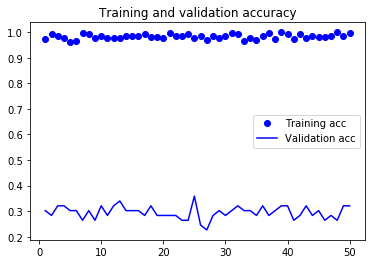

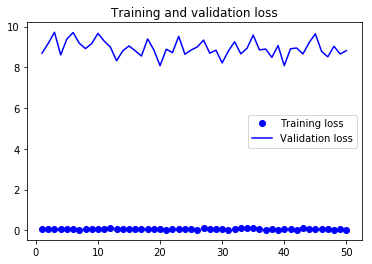

In [13]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()